## TSNE plot of embeddings with sklearn tsne

In [1]:
from __future__ import print_function, absolute_import, division
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import time
import seaborn as sns

Using TensorFlow backend.


In [2]:
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def display_activations(activation_maps):
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.imshow(activations, interpolation='None', cmap='jet')
plt.show()

In [3]:
from heartnet_v2 import heartnet
load_path='/media/taufiq/Data/heart_sound/models/fold1_noFIR 2018-01-24 16:28:06.346153/weights.0083-0.8925.hdf5'
model = heartnet(load_path=load_path)

In [5]:
from heartnet_v1 import reshape_folds
import tables
fold_dir='/media/taufiq/Data/heart_sound/feature/potes_1DCNN/balancedCV/folds/'
foldname='fold1_noFIR'
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]

for i in range(0, y_train.shape[0]):
    if y_train[i] == -1:
        y_train[i] = 0  ## Label 0 for normal 1 for abnormal
for i in range(0, y_val.shape[0]):
    if y_val[i] == -1:
        y_val[i] = 0
x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
print "loading complete"

(78021, 2500, 1)
(78021, 1)
(9834, 2500, 1)
(9834, 1)
loading complete


In [22]:
activations = np.array(get_activations(model,x_val,layer_name='dense_1'))
activations.shape

----- activations -----
[[ 1.57400858  0.          0.         ...,  0.          0.          0.        ]
 [ 0.70993543  0.          0.         ...,  0.          0.          0.        ]
 [ 1.8190558   0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 5.54564762  0.          0.         ...,  0.          0.          0.        ]]


(1, 9834, 20)

In [ ]:
list_path='/media/taufiq/Data/heart_sound/feature/potes_1DCNN/balancedCV/'+'validation'+foldname[4]+'.txt'
import pandas as pd
val_list=pd.read_csv(list_path,header=None)
val_list=val_list.values
flat_list = [item[0] for sublist in val_list for item in sublist]
flat_list=sorted(flat_list)

In [ ]:
t = time.time()
activations=np.reshape(activations,[9834,20])
x_embedded = TSNE(n_components=2,perplexity=500,n_iter=5000,early_exaggeration=1.,init='random').fit_transform(activations)
print(x_embedded.shape)

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(x_embedded[:,0],x_embedded[:,1],c=int(flat_list))
plt.show()

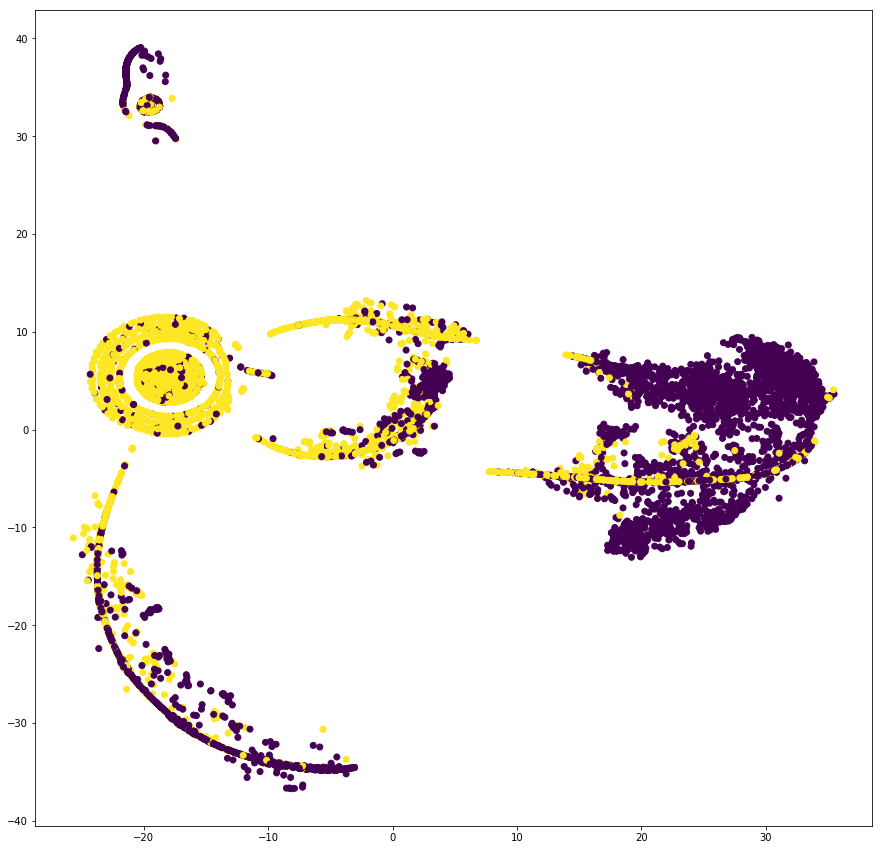

In [61]:
plt.figure(figsize=(15,15))
plt.scatter(x_embedded[:,0],x_embedded[:,1],c=np.reshape(y_val,[9834,]))
plt.show()

In [21]:
sum(y_val-np.reshape(np.hstack(activations),[9834,1])<.5)/9834.

array([ 0.96318894])